In [1]:
from func import *
import matplotlib.pyplot as plt
from tensorflow import summary as sm
from tensorflow import keras
from keras import models, layers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import datetime
import os
import requests
from openpyxl import Workbook
from scipy.signal import butter, lfilter
from sklearn.preprocessing import MinMaxScaler


%load_ext tensorboard

In [2]:
VERSION = 'Main'

FILE_00 = 'data.csv'
FILE_01 = 'data1.csv'
FILE_02 = 'data2.csv'
drop_labels_x = ['Data_Point', 'Test_Time(s)', 'Date_Time', 'Step_Time(s)', 'Step_Index', 'Cycle_Index', 'Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)', 'Internal_Resistance(Ohm)', 'Is_FC_Data','AC_Impedance(Ohm)','ACI_Phase_Angle(Deg)']
drop_labels_y = ['Data_Point', 'Test_Time(s)', 'Date_Time', 'Step_Time(s)', 'Step_Index', 'Cycle_Index', 'Charge_Capacity(Ah)', 'Current(A)', 'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm)', 'Is_FC_Data', 'AC_Impedance(Ohm)','ACI_Phase_Angle(Deg)']

param = {'seq_len' : 10, 'num_units' : 150, 'num_filters' : 128, 'window' : 5, 'dropout': 0.2, 'num_epochs' : 2000, 'num_dense': 80}
batch=500
log_dir = f"logs/{VERSION}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M") + f'-{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
file_path = f'Checkpoints\{VERSION}\SOH_Checkpoint\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ\{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5'
hist_freq = 250

save_path = f'outputs\{VERSION}\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
try:
    if not os.path.exists(save_path):
        os.makedirs(save_path)
except OSError:
    print('Error Creating Directory...')

Index(['Current(A)', 'Voltage(V)', 'dV/dt(V/s)'], dtype='object')
Index(['Voltage(V)'], dtype='object')
Index(['Current(A)', 'Voltage(V)', 'dV/dt(V/s)'], dtype='object')
Index(['Voltage(V)'], dtype='object')
Index(['Current(A)', 'Voltage(V)', 'dV/dt(V/s)'], dtype='object')
Index(['Voltage(V)'], dtype='object')
data00 = (13681, 3)
data00 = [[3.41175532]
 [3.51730466]
 [3.52766538]
 [3.5355978 ]
 [3.54207325]
 [3.54676795]]
p =  [9.99833703e-01 3.51730466e+00 1.29504200e-03]
data00 = <class 'numpy.ndarray'>


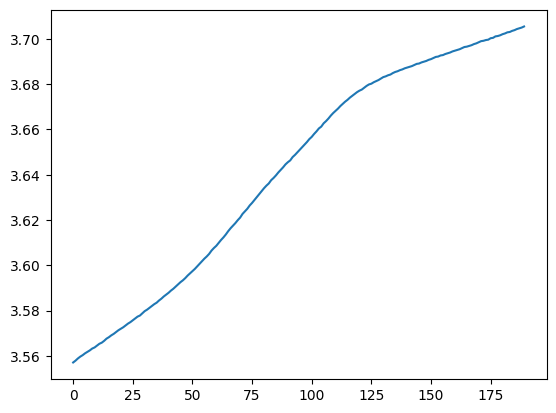

data01 = (12561, 3)


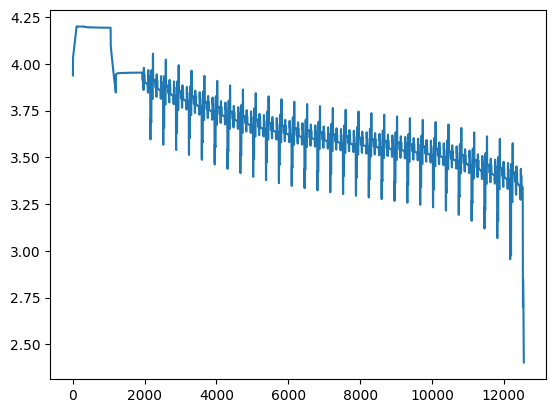

data_test = (12437, 3)


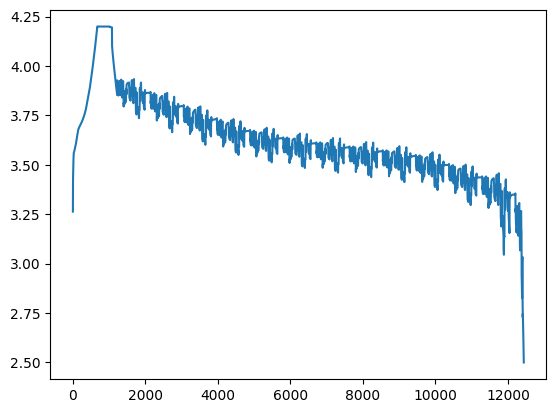

In [3]:
data00, data_cap00 = get_data(FILE_00, drop_labels_x, drop_labels_y)
data01, data_cap01 = get_data(FILE_01, drop_labels_x, drop_labels_y)
data_test, data_cap_test = get_data(FILE_02, drop_labels_x, drop_labels_y)
x_train00 = data00[3681:]
y_train00 = data_cap00[3681:]
x_train01 = data01[2561:]
y_train01 = data_cap01[2561:]
x_test = data_test[2437:]
y_test = data_cap_test[2437:]
p=0
print(f'data00 = {data00.shape}')
print(f'data00 = {data_cap00[0:6]}')
p=data00[0:5]
print(f'p =  {p[1]}')
print(f'data00 = {type(data_cap00)}')
pl.plot(data_cap00[10:200])
pl.show()
print(f'data01 = {data01.shape}')
pl.plot(data_cap01)
pl.show()
print(f'data_test = {data_test.shape}')
pl.plot(data_cap_test)
pl.show()
savedata00 =  data00
savedata_cap00 =  data_cap00
savedata01 =  data01
savedata_cap01 =  data_cap01
savedata_test = data_test
savedata_cap_test = data_cap_test

In [4]:
# mMscaler = MinMaxScaler(feature_range=(0.0001, 1))
# data00= mMscaler.fit_transform(data00)
# data_cap00= mMscaler.fit_transform(data_cap00)
# data01= mMscaler.fit_transform(data01)
# data_cap01= mMscaler.fit_transform(data_cap01)
# data_test= mMscaler.fit_transform(data_test)
# data_cap_test= mMscaler.fit_transform(data_cap_test)




In [5]:
# for i in range(0,10):
#     param['num_units']=param['num_units']+80
#     model = models.Sequential()
#     model.add(layers.Conv1D(param['num_filters'], param['window'], padding='causal', input_shape = (None, x_train00.shape[-1])))
#     model.add(layers.GRU(param['num_units'], return_sequences = True, input_shape = (None, x_train00.shape[-1])))
#     model.add(layers.TimeDistributed(layers.Dense(param['num_dense'])))
#     model.add(layers.TimeDistributed(layers.Dense(1)))
#     model.compile(loss = 'mse', optimizer = 'Adam') 
#     model.summary()
#     callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
#                           TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
#     fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 0, validation_split = 0.2, callbacks=callback_list)
#     callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
#                          TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
#     fitdata = model.fit(x_train01, y_train01, epochs=param['num_epochs'], verbose = 0, validation_split = 0.2, callbacks=callback_list)
#     print(param['num_units'])
#     RMSE, MAE, Error_rate = show_and_prove(model, file_path, x_test, y_test, save_path, return_loss=True)
#     print(f'RMSE({RMSE:.6f}), MAE({MAE:.6f})')

In [6]:
# data00 = data00[Fsize//2:data00.shape[0]-Fsize//2]
# data_cap00 = data_cap00[Fsize//2:data_cap00.shape[0]-Fsize//2]
# data01 = data01[Fsize//2:data01.shape[0]-Fsize//2]
# data_cap01 = data_cap01[Fsize//2:data_cap01.shape[0]-Fsize//2]
# data_test = data_test[Fsize//2:data_test.shape[0]-Fsize//2]
# data_cap_test = data_cap_test[Fsize//2:data_cap_test.shape[0]-Fsize//2]

In [7]:
# print(f'data00 = {data00.shape}')
# print(f'data_cap00 = {data_cap00.shape}')
# print(f'data00 = {data_cap00[0:6]}')
# print(f'data00 = {type(data_cap00)}')
# pl.plot(data_cap00)
# pl.show()
# print(f'data01 = {data01.shape}')
# pl.plot(data_cap01)
# pl.show()
# print(f'data_test = {data_test.shape}')
# pl.plot(data_cap_test)
# pl.show()

In [8]:
# #필터
# Fsize=5
# data00 = lowpass1(data00, Fsize)[Fsize:]
# data_cap00 = lowpass1(data_cap00,Fsize)[Fsize:]
# data01 = lowpass1(data01,Fsize)[Fsize:]
# data_cap01 = lowpass1(data_cap01,Fsize)[Fsize:]
# data_test = lowpass1(data_test,Fsize)[Fsize:]
# data_cap_test = lowpass1(data_cap_test,Fsize)[Fsize:]
# size=(int)(savedata00.shape[0]-Fsize/2)
# savedata00 =  savedata00[Fsize:size]
# savedata_cap00 =  savedata_cap00[Fsize:size]
# savedata01 =  savedata01[Fsize:size]
# savedata_cap01 =  savedata_cap01[Fsize:size]
# savedata_test = savedata_test[Fsize:size]
# savedata_cap_test = savedata_cap_test[Fsize:size]

# print(f'data00 = {data00.shape}')
# print(f'savedata00 = {savedata_cap_test.shape}')

In [9]:
x_train00 = x_train00.reshape((x_train00.shape[0], x_train00.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train00))

idx = np.random.permutation(len(x_train00))
x_train00 = x_train00[idx]
y_train00 = y_train00[idx]

y_train00[y_train00 == -1] = 0
y_test[y_test == -1] = 0
print(x_train00.shape)
print(y_train00.shape)
# print(x_train00[0, 0:6, 1])
# count=savedata_cap_test.shape[0]-y_test.shape[0]*y_test.shape[1]
# print(count)

(10000, 3, 1)
(10000, 1)


In [10]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [11]:
n_classes = len(np.unique(y_train00))
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [12]:
input_shape = x_train00.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    x_train00,
    y_train00,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.save_weights('cifar10-weight.h5')
model.evaluate(x_test, y_test, verbose=1)
score = model.evaluate(x_test, y_test, verbose=1)
print('정답률 = ', score[1],'loss=', score[0])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 3, 1)        2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 3, 1)        7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

(10000, 3, 1)
(10000, 1)
313/313 [==============================] - 1s 4ms/step - loss: 0.0382 - sparse_categorical_accuracy: 0.0000e+00
정답률 =  0.0 loss= 0.03823953494429588
313/313 [==============================] - 1s 2ms/step
(10000, 3178)
(10000, 1)
(10000, 1)
......
outputs\Main\128FL-150UN-2000EP-10SQ
(10000, 1)
(10000, 1)


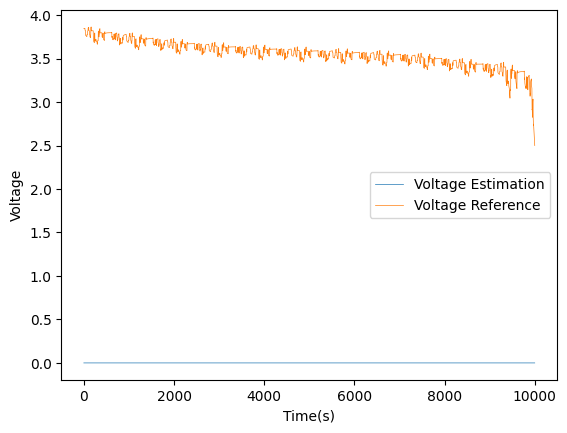

In [36]:
#필터 안적용시
from calendar import EPOCH
import pandas
print(x_test.shape)
print(y_test.shape)
score = model.evaluate(x_test, y_test, verbose=1)
print('정답률 = ', score[1],'loss=', score[0])
# x_test = mMscaler.inverse_transform(x_test)
model.load_weights('cifar10-weight.h5')
prediction_graph = model.predict(x_test)
print(prediction_graph.shape)
prediction_graph=prediction_graph[:,0]
prediction_graph = flatten_2Dto1D(prediction_graph)
y_graph=y_test
# y_test = mMscaler.inverse_transform(y_test)
print(prediction_graph.shape)
print(y_test.shape)
print('......')
print(save_path)
# prediction_graph=relow(prediction_graph, savedata_cap_test, Fsize)
# savedata_cap_test=savedata_cap_test[Fsize:]
print(prediction_graph.shape)
print(y_graph.shape)
pl.ylabel('Voltage')
pl.xlabel('Time(s)')
line = pl.plot(prediction_graph, label = 'Voltage Estimation')
pl.setp(line, linewidth=0.5)

# y_line = pl.plot(savedata_cap_test, label = 'Voltage Reference')
y_line = pl.plot(y_graph, label = 'Voltage Reference')
pl.setp(y_line, linewidth=0.5)
pl.legend()
pl.savefig(f'{save_path}\Estimation.png')
pl.show()

In [ ]:
#필터 안적용시
Error_rate = []
Error = []

for step in range(len(prediction_graph)):
        # Error_rate.append((prediction_graph[step] - savedata_cap_test[step]) / savedata_cap_test[step] * 100)
        Error_rate.append((prediction_graph[step] - y_graph[step]) / y_graph[step] * 100)
        Error.append(Error_rate[step] / 100)
    

RMSE_total = np.sqrt(np.mean(np.square(Error)))
MAE_total = np.mean(np.absolute(Error))
pl.figure(dpi=150)
line = pl.plot(Error_rate)
pl.ylim(-10, 10)
pl.ylabel('SOC Error (%)')
pl.xlabel('time(s)')
pl.setp(line, color='b', linewidth=0.5)
pl.show()
print(f'RMSE({RMSE_total:.6f}), MAE({MAE_total:.6f})')

In [ ]:
# #필터적용시
# from calendar import EPOCH

# RMSE_total, MAE_total, Error_rate, prediction_graph, y_graph = prove(model, file_path, x_test, y_test)
# print(prediction_graph.shape)
# print(y_graph.shape)
# print(savedata_cap_test.shape)
# print('......')
# prediction_graph=relow2(prediction_graph, y_graph, Fsize)
# lsize=(int)(y_graph.shape[0]-Fsize/2)
# prediction_graph=prediction_graph[Fsize:]
# y_graph=y_graph[Fsize:lsize]

# print(prediction_graph.shape)
# print(y_graph.shape)
# pl.figure(dpi=2500)
# pl.ylabel('Voltage')
# pl.xlabel('Time(s)')
# line = pl.plot(prediction_graph, label = 'Voltage Estimation')
# pl.setp(line, linewidth=0.5)

# y_line = pl.plot(y_graph, label = 'Voltage Reference')
# # y_line = pl.plot(y_graph, label = 'Voltage Reference')
# pl.setp(y_line, linewidth=0.5)
# pl.legend()
# pl.savefig(f'{save_path}\Estimation.png')
# pl.show()

In [ ]:
# #필터 적용시
# Error_rate = []
# Error = []

# for step in range(len(prediction_graph)):
#         Error_rate.append((prediction_graph[step] - y_graph[step]) / y_graph[step] * 100)
#         # Error_rate.append((prediction_graph[step] - y_graph[step]) / y_graph[step] * 100)
#         Error.append(Error_rate[step] / 100)
    

# RMSE_total = np.sqrt(np.mean(np.square(Error)))
# MAE_total = np.mean(np.absolute(Error))
# pl.figure(dpi=150)
# line = pl.plot(Error_rate)
# pl.ylim(-10, 10)
# pl.ylabel('SOC Error (%)')
# pl.xlabel('time(s)')
# pl.setp(line, color='b', linewidth=0.5)
# pl.show()
# print(f'RMSE({RMSE_total:.6f}), MAE({MAE_total:.6f})')

In [ ]:
print(prediction_graph.shape)
print(y_graph.shape)